# Import Libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error, roc_auc_score, mean_absolute_error, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


# Import Data

In [14]:
train_df = pd.read_csv("../../data/train_data_v2.csv")
validate_df = pd.read_csv("../../data/validate_data_v2.csv")
test_df = pd.read_csv("../../data/test_data_v2.csv")

In [15]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 75)
(1000, 75)
(1000, 75)


# Evaluation Function

In [16]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    # Accuracy1: Exact match (diagonal of confusion matrix)
    acc1 = np.mean(y_pred == y_test)
    print("Accuracy1 (Exact match):", acc1)

    # Accuracy2: One-off accuracy (prediction is within ±1 of true label)
    one_off = np.abs(y_pred - y_test) <= 1
    acc2 = np.mean(one_off)
    print("Accuracy2 (One-off accuracy):", acc2)


    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Feature Importance Function

In [17]:
def plot_top_feature_importances(model, X, selector=None, top_n=10):
    """
    Plots the top N feature importances from a trained model.
    
    Parameters:
    - model: Trained sklearn model with feature_importances_ attribute
    - X: Original (full) training feature DataFrame
    - selector: RFE selector used to reduce features (optional)
    - top_n: Number of top features to display
    """
    if selector is not None:
        # Filter features using RFE support mask
        feature_names = X.columns[selector.support_]
    else:
        feature_names = X.columns

    # Create a DataFrame with importances and feature names
    importances = model.feature_importances_
    feat_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
    plt.xlabel("Feature Importance Score")
    plt.ylabel(f"Top {top_n} Features")
    plt.title(f"Top {top_n} Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Define Features & Target

In [18]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [19]:

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_validate)

Accuracy: 0.516
F1 Score: 0.5896084283568299
Classification Report:
               precision    recall  f1-score   support

           1       0.20      1.00      0.33        14
           2       0.97      0.47      0.63       828
           3       0.34      0.72      0.46       124
           4       0.10      0.76      0.17        34

    accuracy                           0.52      1000
   macro avg       0.40      0.74      0.40      1000
weighted avg       0.85      0.52      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 45 387 172 224]
 [ 11   8  89  16]
 [  0   4   4  26]]
Accuracy1 (Exact match): 0.516
Accuracy2 (One-off accuracy): 0.761


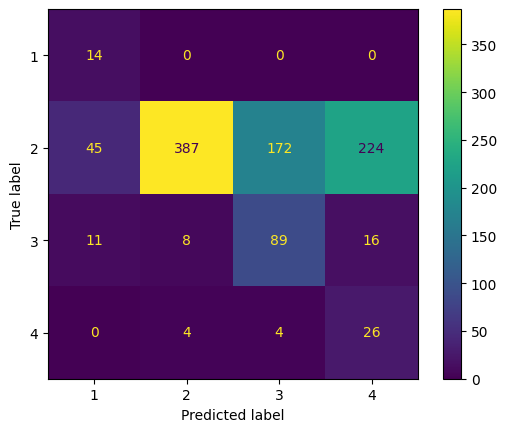

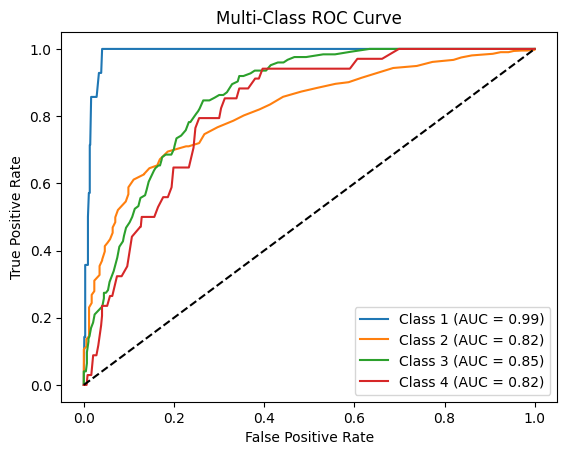

In [20]:
evaluate(y_pred, y_validate, X_validate, model)


Accuracy: 0.525
F1 Score: 0.6180886433945847
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.50      0.66       857
           3       0.33      0.68      0.44       119
           4       0.05      0.72      0.09        18

    accuracy                           0.53      1000
   macro avg       0.37      0.72      0.35      1000
weighted avg       0.87      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 33 425 164 235]
 [ 12  11  81  15]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.525
Accuracy2 (One-off accuracy): 0.75


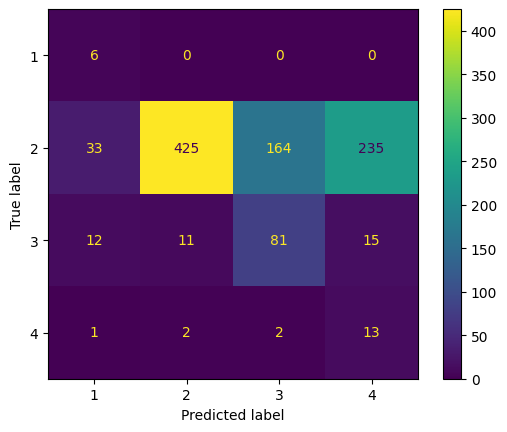

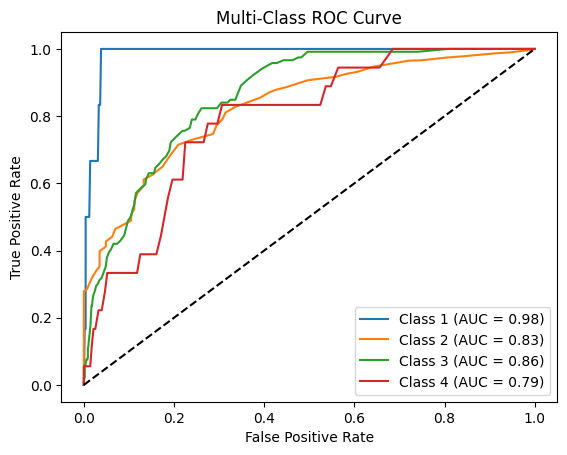

In [21]:
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, X_test, model)


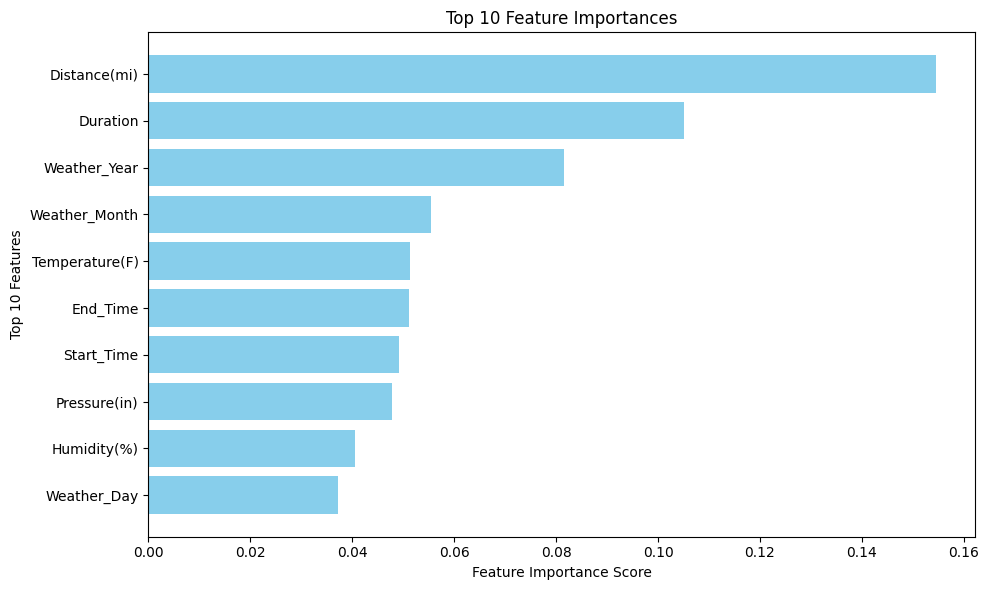

In [22]:
plot_top_feature_importances(model, X_train, selector=None, top_n=10)

# Backward Selection

In [23]:
def feature_selection_evaluate(n_features, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(random_state=42)
    selector = RFE(model, n_features_to_select=n_features, step=1)

    # Train a new Random Forest model on the reduced feature set
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print("Selected features: ", selected_features)

    # Transform both training and validation datasets
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)

    model.fit(X_train_selected, y_train)

    y_pred_validate = model.predict(X_validate_selected)
    evaluate(y_pred_validate, y_validate, X_validate_selected, model)

    y_pred_test = model.predict(X_test_selected)
    evaluate(y_pred_test, y_test, X_test_selected, model)

    plot_top_feature_importances(model, X_train, selector=selector, top_n=n_features)

    return model, selector

Selected features:  Index(['Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Traffic_Signal',
       'Duration', 'Region', 'State_Others', 'Weather_Year', 'Weather_Month',
       'Weather_Day', 'Weather_Hour'],
      dtype='object')
Accuracy: 0.524
F1 Score: 0.5952429107015379
Classification Report:
               precision    recall  f1-score   support

           1       0.23      1.00      0.38        14
           2       0.97      0.48      0.64       828
           3       0.33      0.74      0.45       124
           4       0.10      0.71      0.17        34

    accuracy                           0.52      1000
   macro avg       0.41      0.73      0.41      1000
weighted avg       0.85      0.52      0.60      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 32 394 187 215]
 [ 13   7  92  12]
 [  1   7   2  24]]
Accuracy1 (Exact match): 0.524
Accuracy2 (One-off accuracy): 0.764


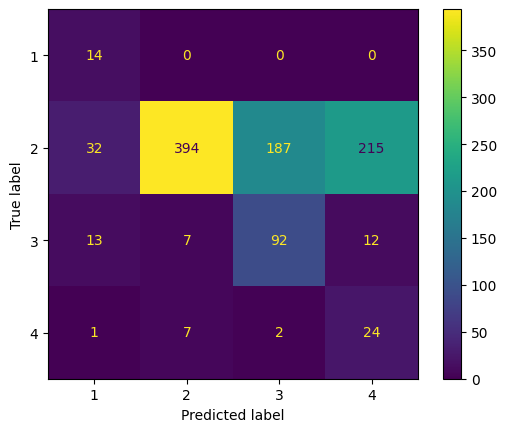

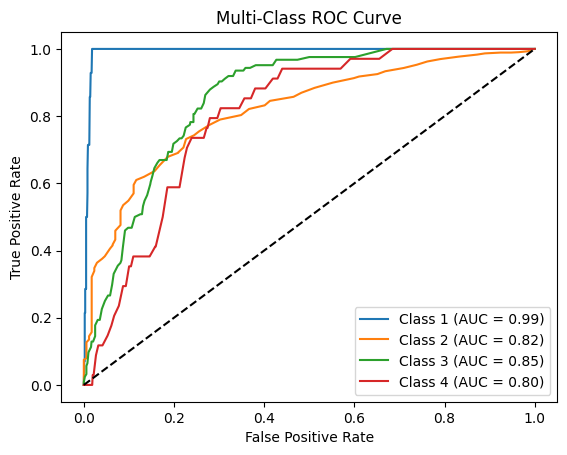

Accuracy: 0.529
F1 Score: 0.6183734787152492
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.50      0.66       857
           3       0.31      0.69      0.43       119
           4       0.06      0.78      0.11        18

    accuracy                           0.53      1000
   macro avg       0.36      0.74      0.35      1000
weighted avg       0.87      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 33 427 177 220]
 [ 11  13  82  13]
 [  1   1   2  14]]
Accuracy1 (Exact match): 0.529
Accuracy2 (One-off accuracy): 0.767


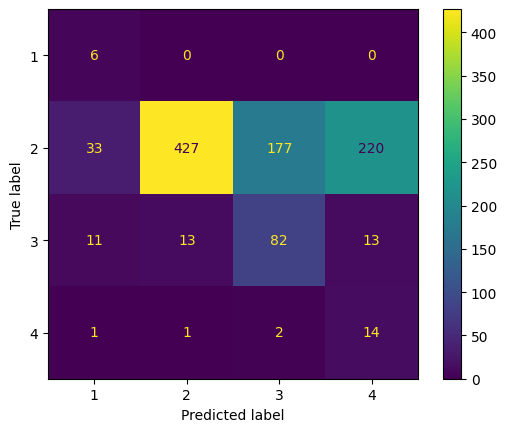

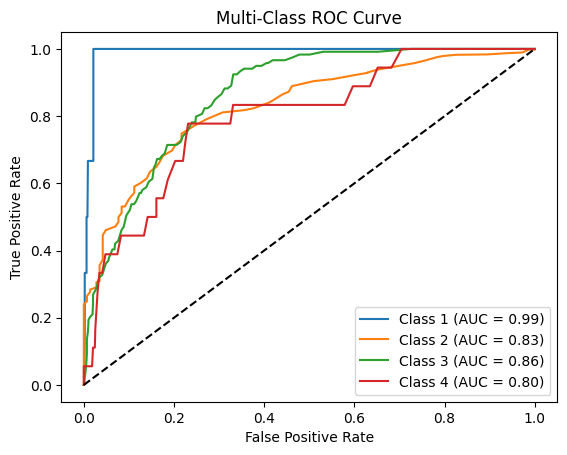

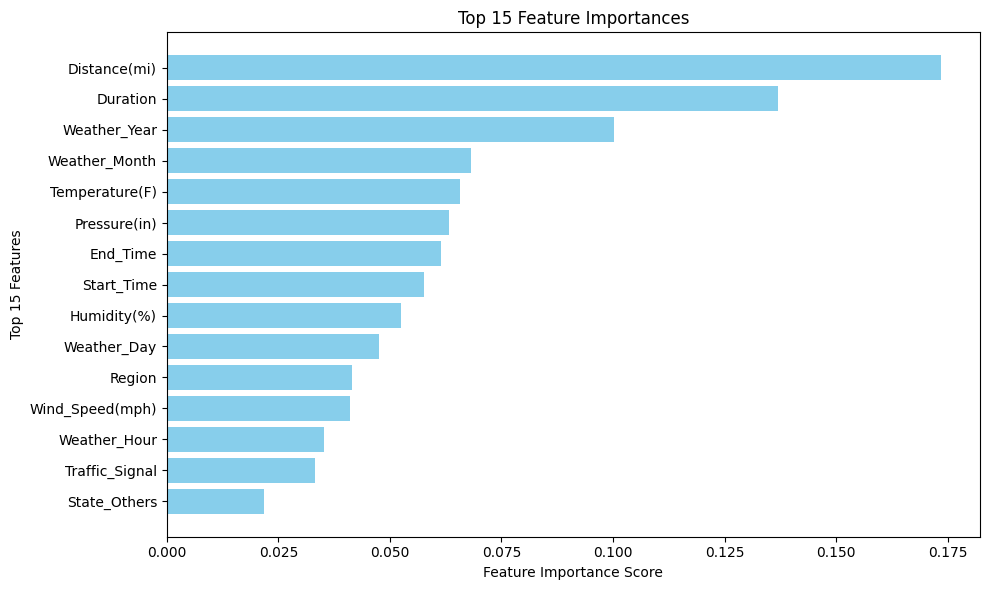

In [24]:
model, selector = feature_selection_evaluate(15, X_train, y_train, X_test, y_test)

Selected features:  Index(['Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Crossing', 'Traffic_Signal', 'Duration', 'Region',
       'State_CA', 'State_Others', 'City_Others', 'Weather_Year',
       'Weather_Month', 'Weather_Day', 'Weather_Hour'],
      dtype='object')
Accuracy: 0.54
F1 Score: 0.6134681634120335
Classification Report:
               precision    recall  f1-score   support

           1       0.21      1.00      0.34        14
           2       0.97      0.50      0.66       828
           3       0.34      0.70      0.46       124
           4       0.10      0.76      0.18        34

    accuracy                           0.54      1000
   macro avg       0.41      0.74      0.41      1000
weighted avg       0.85      0.54      0.61      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 40 413 166 209]
 [ 14   8  87  15]
 [  0   4   4  26]]
Accuracy1 (Exac

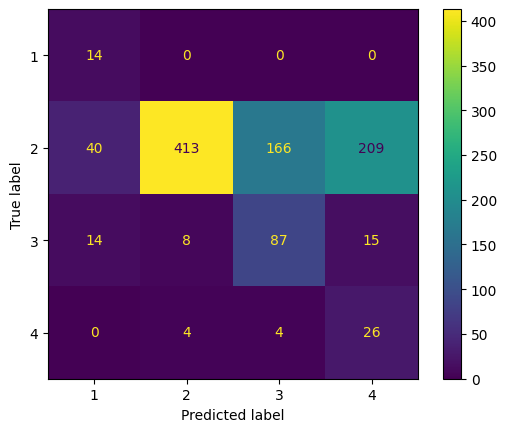

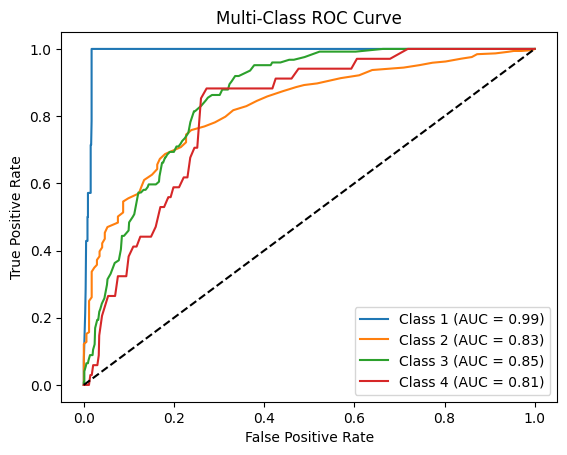

Accuracy: 0.539
F1 Score: 0.6298820849711614
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.51      0.67       857
           3       0.32      0.67      0.43       119
           4       0.05      0.72      0.10        18

    accuracy                           0.54      1000
   macro avg       0.36      0.73      0.35      1000
weighted avg       0.87      0.54      0.63      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 32 440 168 217]
 [ 13  12  80  14]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.539
Accuracy2 (One-off accuracy): 0.767


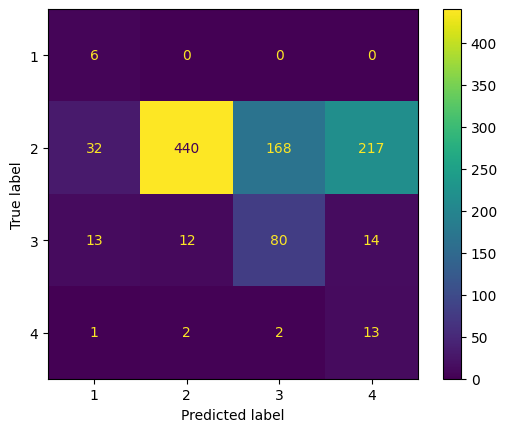

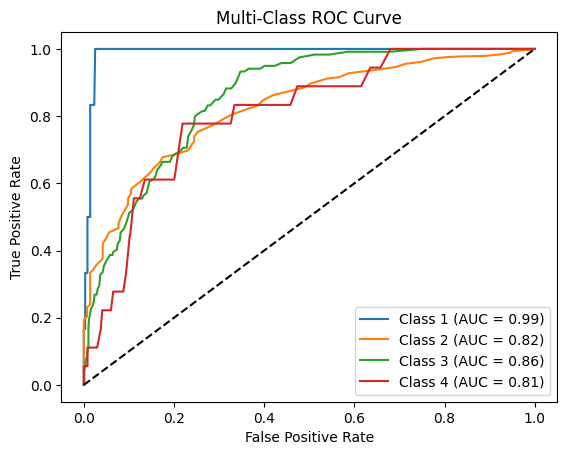

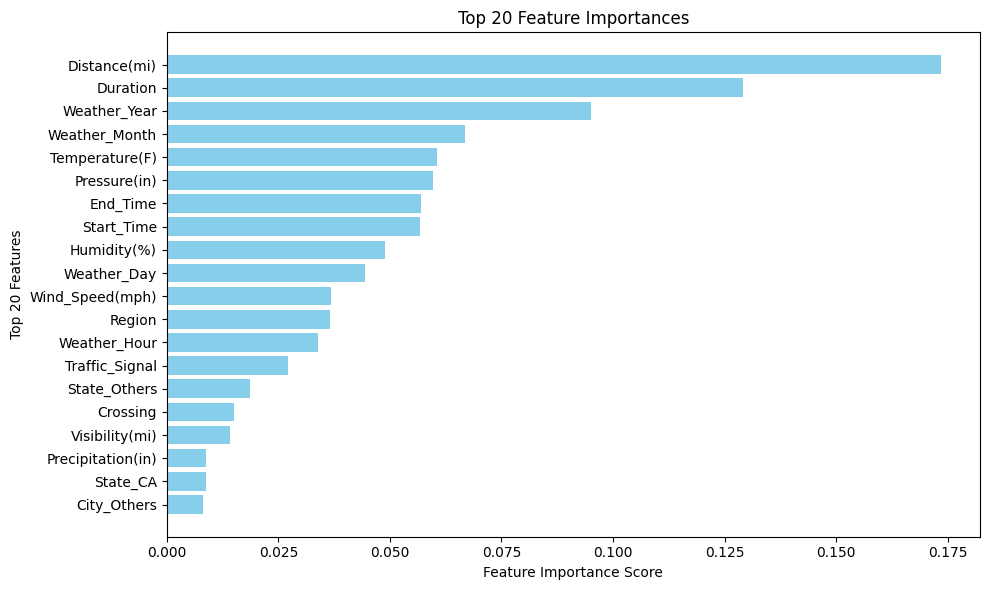

In [25]:
model, selector = feature_selection_evaluate(20, X_train, y_train, X_test, y_test)

##### Save best model and selector

In [26]:
import joblib

joblib.dump(model, 'best_models/random_forest_model.pkl')
joblib.dump(selector, 'best_models/random_forest_rfe_selector.pkl')


['best_models/random_forest_rfe_selector.pkl']

Selected features:  Index(['Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Crossing', 'Traffic_Signal', 'Duration', 'Region',
       'State_CA', 'State_Others', 'City_Others', 'Weather_Year',
       'Weather_Month', 'Weather_Day', 'Weather_Hour',
       'Weather_Day_of_Week_Friday', 'Weather_Day_of_Week_Monday',
       'Weather_Day_of_Week_Thursday', 'Weather_Day_of_Week_Tuesday',
       'Weather_Day_of_Week_Wednesday'],
      dtype='object')
Accuracy: 0.523
F1 Score: 0.5953209690392527
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.36        14
           2       0.97      0.47      0.64       828
           3       0.33      0.73      0.45       124
           4       0.10      0.74      0.17        34

    accuracy                           0.52      1000
   macro avg       0.40      0.74      0.4

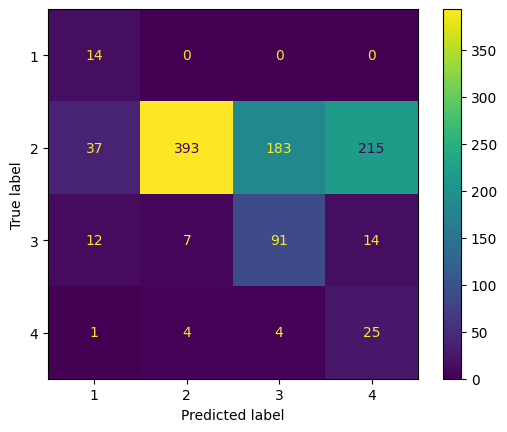

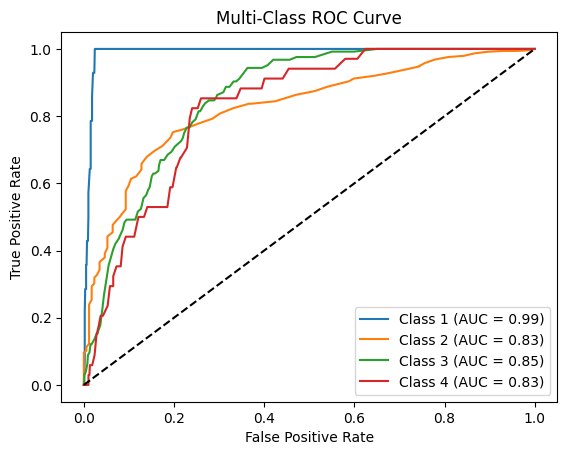

Accuracy: 0.533
F1 Score: 0.6243926754321556
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.97      0.50      0.66       857
           3       0.33      0.69      0.44       119
           4       0.05      0.72      0.10        18

    accuracy                           0.53      1000
   macro avg       0.37      0.73      0.35      1000
weighted avg       0.87      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 35 432 167 223]
 [ 12  11  82  14]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.533
Accuracy2 (One-off accuracy): 0.762


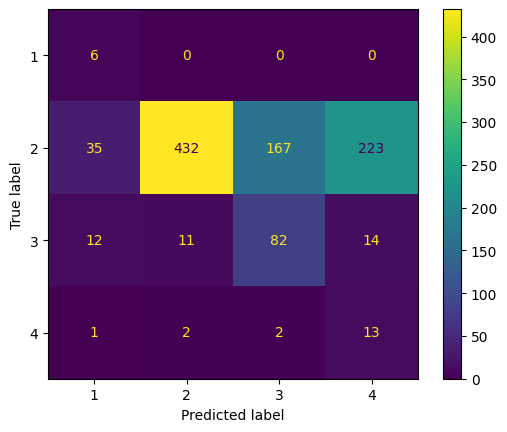

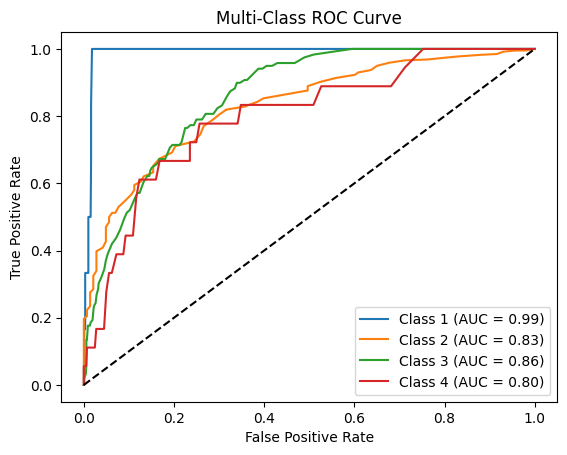

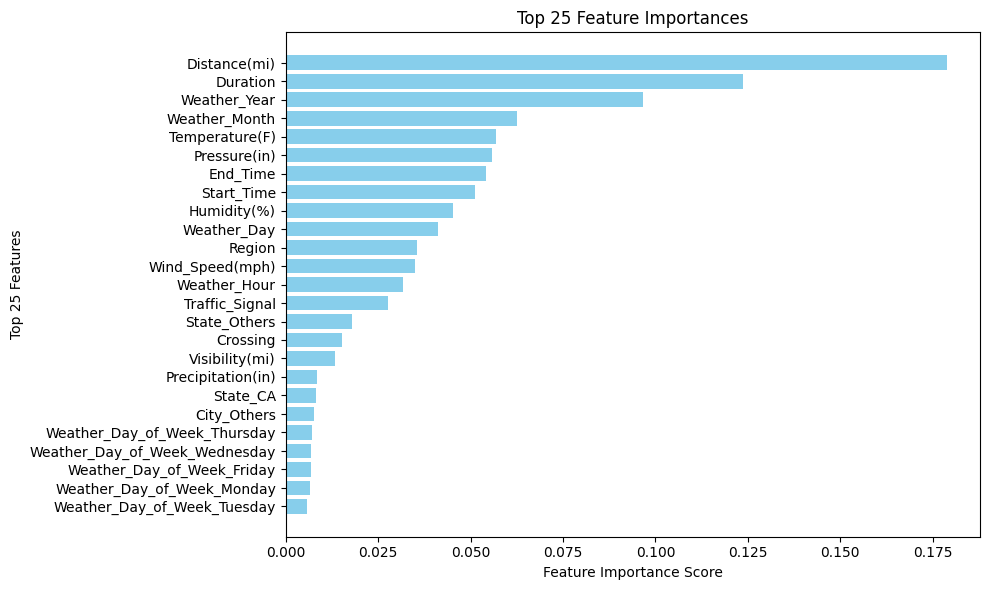

In [27]:
model, selector = feature_selection_evaluate(25, X_train, y_train, X_test, y_test)

# Hyperparameter Tuning

In [15]:
from sklearn.metrics import make_scorer

def tune_rf_with_rfe(X_train, y_train, X_validate, y_validate, X_test, y_test, param_grid, n_features=20):
    """
    Perform Recursive Feature Elimination (RFE) with RandomForest, followed by hyperparameter tuning 
    using GridSearchCV with F1 scoring and 5-fold cross-validation.

    Parameters:
    - X_train, y_train: Training data and labels
    - X_validate, y_validate: Validation data and labels
    - X_test, y_test: Test data and labels
    - n_features: Number of features to select using RFE

    Returns:
    - best_model: The best Random Forest model after tuning
    """
    
    # Step 1: Perform Recursive Feature Elimination (RFE)
    selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train)

    # Select only important features
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)


    # Define a custom scorer for F1 (weighted)
    f1_scorer = make_scorer(f1_score, average='weighted')

    # Step 3: Initialize GridSearchCV with cross-validation and F1 scorer
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,  # Cross-validation folds
        scoring=f1_scorer,  # Use F1 weighted scorer
        n_jobs=-1,  # Use all available CPUs
        verbose=2
    )

    # Step 4: Fit the grid search to the **selected feature** training data
    grid_search.fit(X_train_selected, y_train)

    # Step 5: Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters found: ", grid_search.best_params_)

    # Step 6: Make predictions using the best model on the validation set
    y_pred_validate = best_model.predict(X_validate_selected)
    print("\nEvaluate (Validation Set):")
    evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)

    # Step 7: Evaluate on the test set
    y_pred_test = best_model.predict(X_test_selected)
    print("\nEvaluate (Test Set):")
    evaluate(y_pred_test, y_test, X_test_selected, best_model)

    plot_top_feature_importances(best_model, X_train, selector=selector, top_n=n_features)
    return best_model


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END ccp_

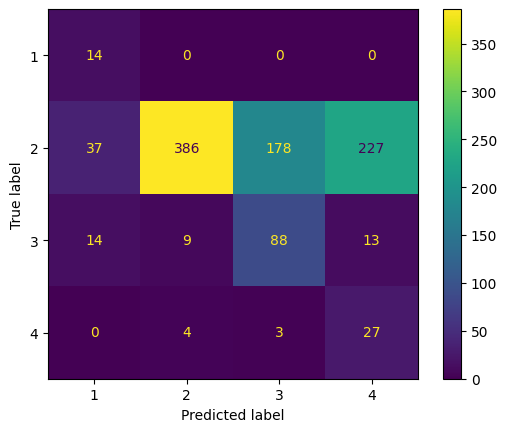

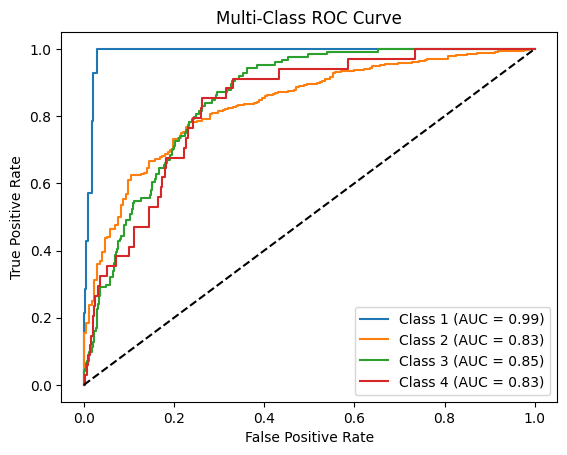


Evaluate (Test Set):
Accuracy: 0.536
F1 Score: 0.6265172889488678
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.51      0.67       857
           3       0.32      0.70      0.44       119
           4       0.05      0.67      0.09        18

    accuracy                           0.54      1000
   macro avg       0.36      0.72      0.35      1000
weighted avg       0.87      0.54      0.63      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 32 435 174 216]
 [ 12  10  83  14]
 [  1   3   2  12]]
Accuracy1 (Exact match): 0.536
Accuracy2 (One-off accuracy): 0.768


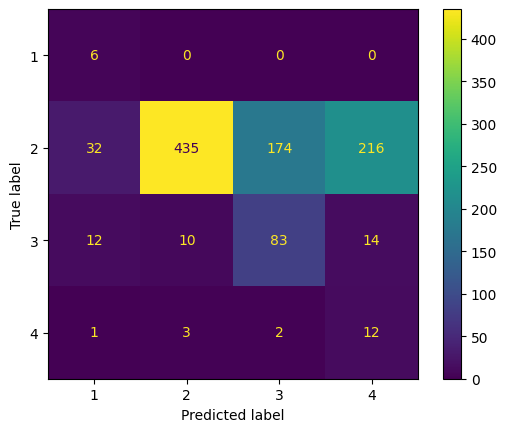

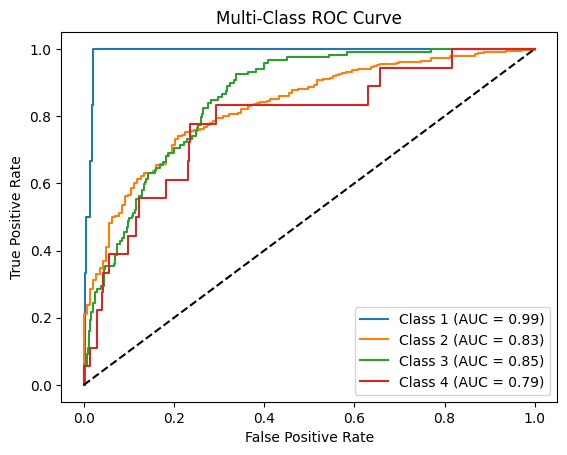

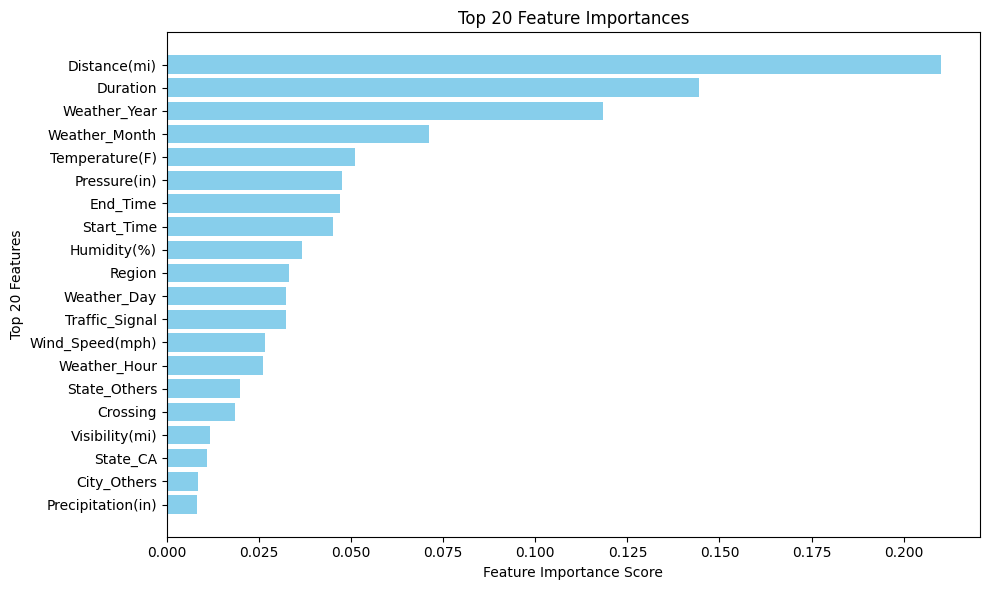

In [16]:
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'ccp_alpha': [0.0, 0.01, 0.1],  
    'max_samples': [None, 0.5, 0.8]  
}
best_model = tune_rf_with_rfe(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    n_features=20  
)

Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': 20, 'max_samples': None, 'min_samples_split': 10, 'n_estimators': 100}


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=80; total time=   0.8s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=80; total time=   0.8s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=80; total time=   0.8s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=80; total time=   0.8s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=80; total time=   1.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=120; total time=   1.2s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=120; total time=   1.2s
[CV] END ccp_alpha=0, max_depth=15, max_samples=None, min_samples_split=8, n_estimators=120; total time=   1.2s
[CV] END ccp_alpha=0, max_depth=15, max_samples=

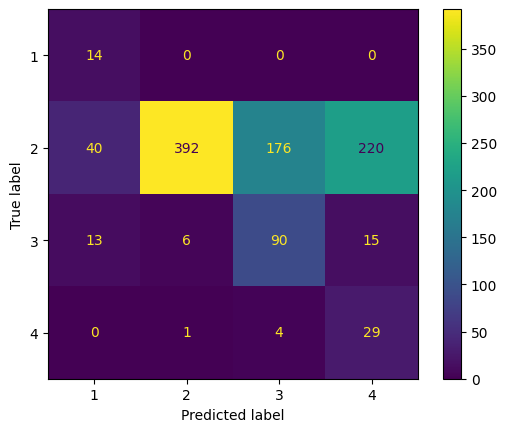

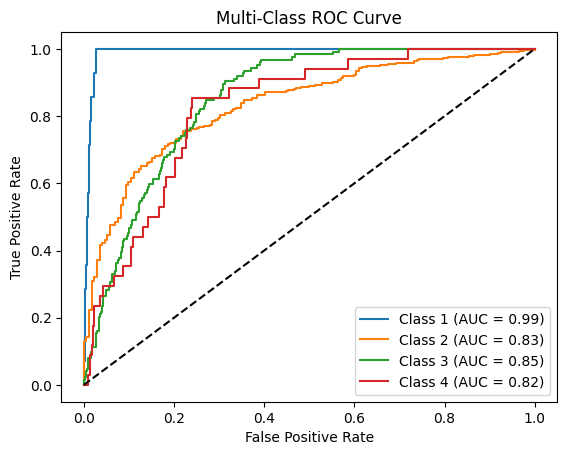


Evaluate (Test Set):
Accuracy: 0.528
F1 Score: 0.6193151664176635
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.97      0.50      0.66       857
           3       0.32      0.71      0.45       119
           4       0.05      0.67      0.09        18

    accuracy                           0.53      1000
   macro avg       0.37      0.72      0.35      1000
weighted avg       0.88      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 34 425 175 223]
 [ 12   8  85  14]
 [  1   3   2  12]]
Accuracy1 (Exact match): 0.528
Accuracy2 (One-off accuracy): 0.761


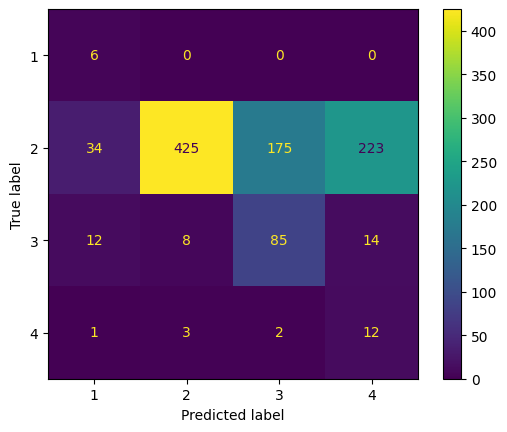

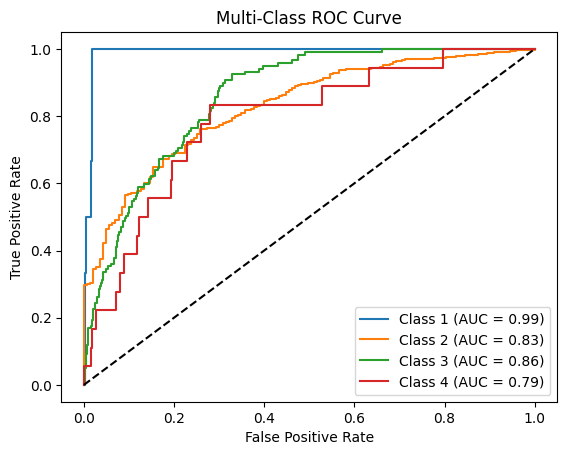

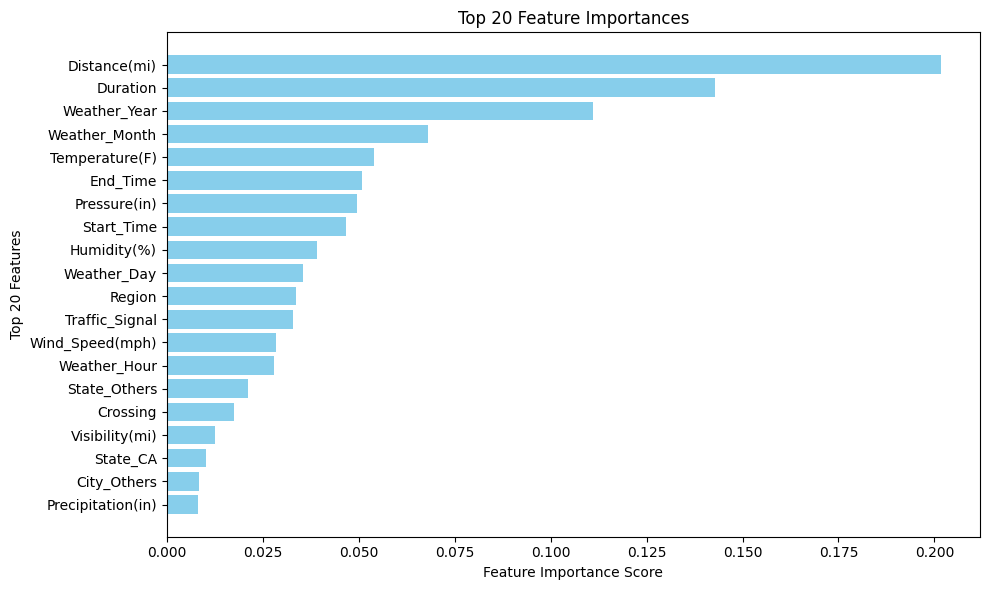

In [17]:
param_grid = {
    'n_estimators': [80, 120],  
    'max_depth': [15, 25],  
    'min_samples_split': [8, 12],  
    'ccp_alpha': [0, 0.001],  
    'max_samples': [None]  
}
best_model = tune_rf_with_rfe(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    n_features=20  
)


Best parameters found:  {'ccp_alpha': 0, 'max_depth': 25, 'max_samples': None, 'min_samples_split': 8, 'n_estimators': 120}


# Hyperparameter Tuning with BayesSearch

In [43]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [44]:
def tune_evaluate(X_train, y_train, X_validate, y_validate, X_test, y_test, param_grid, scorer, n_features=20):
    # Step 1: Perform Recursive Feature Elimination (RFE)
    # Step 1: Perform Recursive Feature Elimination (RFE)
    selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train)

    # Select only important features
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)
    
    
    opt = BayesSearchCV(estimator=RandomForestClassifier(random_state=42),                                    
                    search_spaces=param_grid,                      
                    scoring=scorer,                           
                    cv=5,                                           
                    n_iter=60,
                    n_points=3,
                    n_jobs=-1,
                    iid=False,
                    return_train_score=False,                         
                    refit=True,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        
                    random_state=42)
    
    opt.fit(X_train_selected, y_train)
    best_model = opt.best_estimator_
    print("Best optimzer score: ", opt.best_score_)
    print("Best parameters: ", opt.best_params_)

    # Step 6: Make predictions using the best model on the validation set
    y_pred_validate = best_model.predict(X_validate_selected)
    print("\nEvaluate (Validation Set):")
    evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)

    # Step 7: Evaluate on the test set
    y_pred_test = best_model.predict(X_test_selected)
    print("\nEvaluate (Test Set):")
    evaluate(y_pred_test, y_test, X_test_selected, best_model)

    plot_top_feature_importances(best_model, X_train, selector=selector, top_n=n_features)

    return best_model, opt.best_params_

In [49]:
param_grid = {
    'n_estimators': Integer(30, 5000),        # Number of trees in the model
    'max_depth': Integer(1, 256), 
    'min_samples_split': Integer(2, 50),  
    'ccp_alpha': Real(0.0001, 0.05, 'log-uniform'),  
    'max_samples': Real(0.5, 1.0)  
}

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(
/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best optimzer score:  0.7323239212214309
Best parameters:  OrderedDict({'ccp_alpha': 0.0001, 'max_depth': 38, 'max_samples': 1.0, 'min_samples_split': 2, 'n_estimators': 2005})

Evaluate (Validation Set):
Accuracy: 0.522
F1 Score: 0.5945936389742293
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.35        14
           2       0.98      0.47      0.64       828
           3       0.34      0.73      0.46       124
           4       0.10      0.79      0.18        34

    accuracy                           0.52      1000
   macro avg       0.41      0.75      0.41      1000
weighted avg       0.86      0.52      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 39 390 177 222]
 [ 12   5  91  16]
 [  0   4   3  27]]
Accuracy1 (Exact match): 0.522
Accuracy2 (One-off accuracy): 0.762


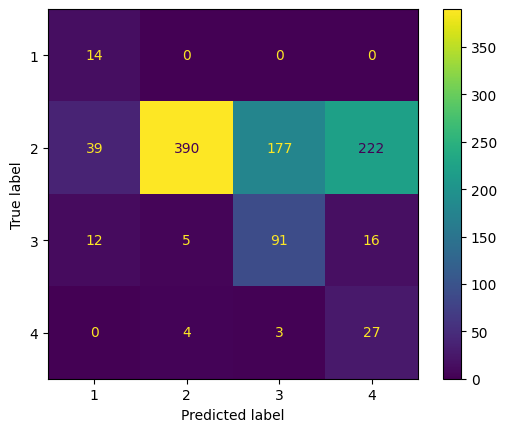

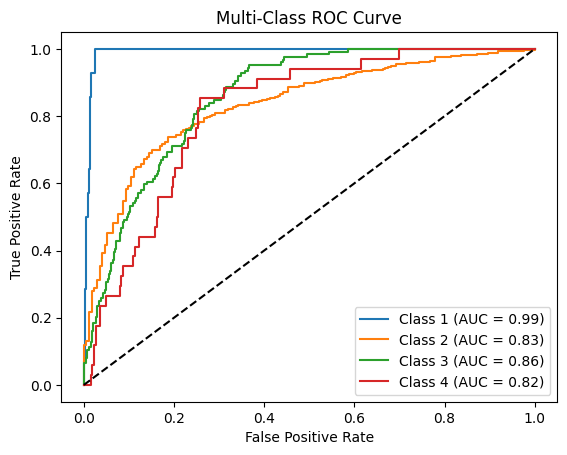


Evaluate (Test Set):
Accuracy: 0.534
F1 Score: 0.625163257718302
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.51      0.67       857
           3       0.32      0.68      0.43       119
           4       0.05      0.72      0.10        18

    accuracy                           0.53      1000
   macro avg       0.36      0.73      0.35      1000
weighted avg       0.87      0.53      0.63      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 32 434 171 220]
 [ 12  11  81  15]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.534
Accuracy2 (One-off accuracy): 0.765


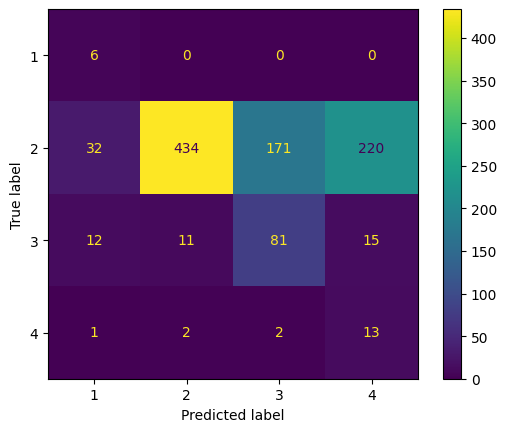

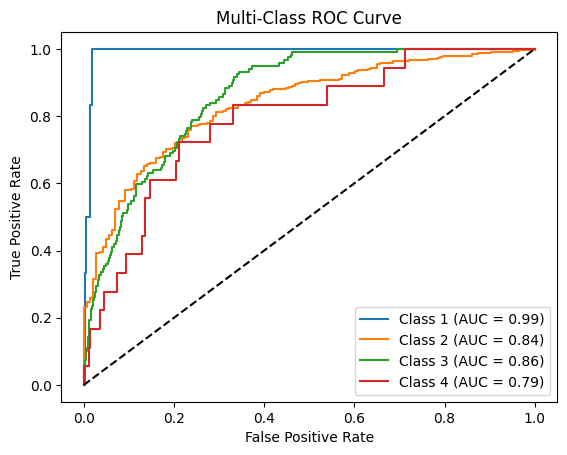

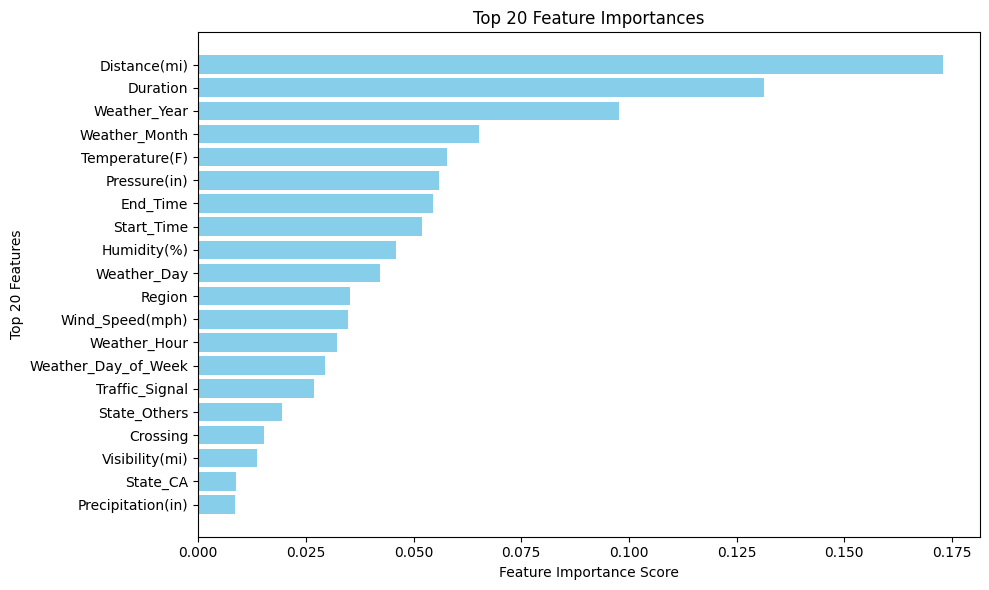

In [50]:
scorer = make_scorer(f1_score, average="weighted", greater_is_better=True)
best_model_mse1, best_params_mse1 = tune_evaluate(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    scorer=scorer,
    n_features=20
)


/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(
/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best optimzer score:  -0.745125
Best parameters:  OrderedDict({'ccp_alpha': 0.0001, 'max_depth': 74, 'max_samples': 0.9528027463311879, 'min_samples_split': 2, 'n_estimators': 2732})

Evaluate (Validation Set):
Accuracy: 0.52
F1 Score: 0.5921420854092181
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.36        14
           2       0.97      0.47      0.63       828
           3       0.33      0.73      0.46       124
           4       0.10      0.79      0.18        34

    accuracy                           0.52      1000
   macro avg       0.41      0.75      0.41      1000
weighted avg       0.86      0.52      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 38 388 179 223]
 [ 11   6  91  16]
 [  0   4   3  27]]
Accuracy1 (Exact match): 0.52
Accuracy2 (One-off accuracy): 0.762


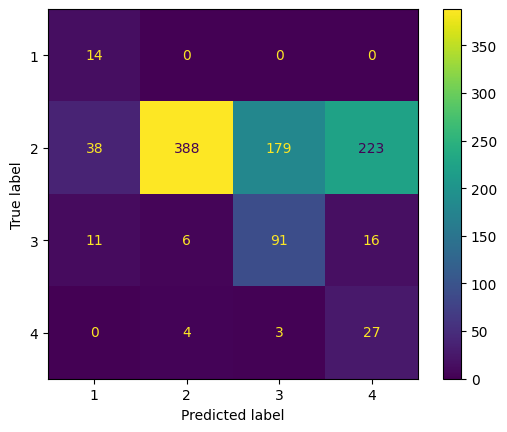

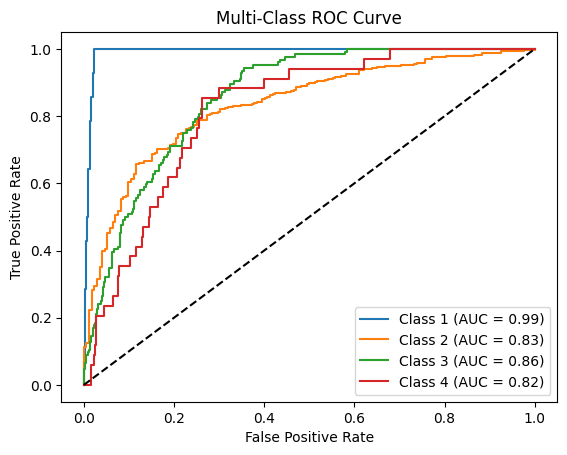


Evaluate (Test Set):
Accuracy: 0.533
F1 Score: 0.6248935916611491
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.98      0.50      0.66       857
           3       0.32      0.69      0.44       119
           4       0.05      0.72      0.10        18

    accuracy                           0.53      1000
   macro avg       0.37      0.73      0.35      1000
weighted avg       0.88      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 32 432 170 223]
 [ 12   9  82  16]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.533
Accuracy2 (One-off accuracy): 0.762


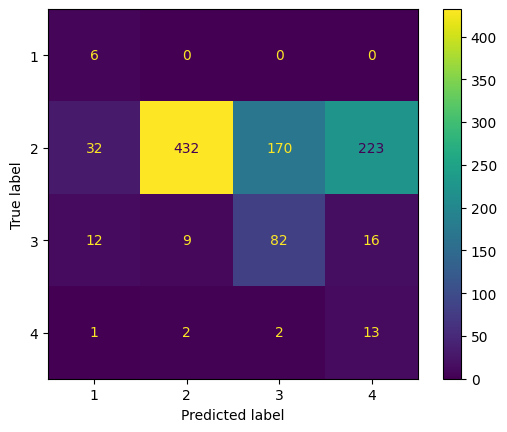

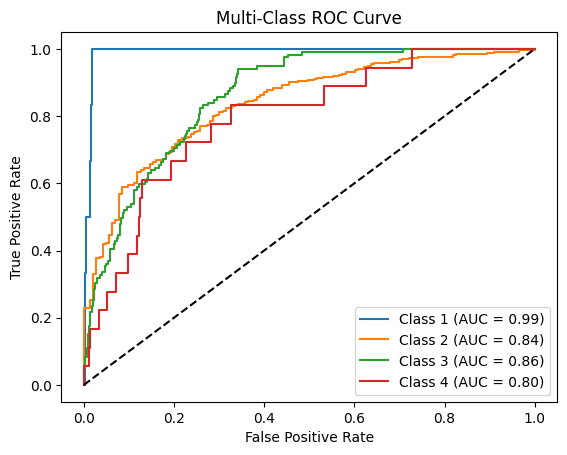

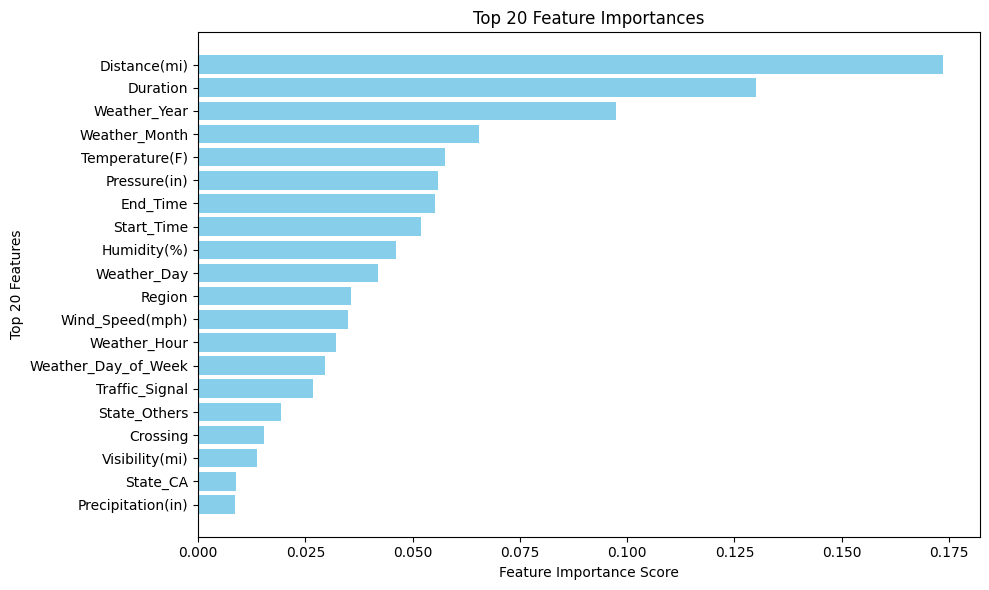

In [51]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
best_model_mse1, best_params_mse1 = tune_evaluate(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    scorer=scorer,
    n_features=20
)


/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(


Best optimzer score:  -0.4165
Best parameters:  OrderedDict({'ccp_alpha': 0.0001, 'max_depth': 210, 'max_samples': 1.0, 'min_samples_split': 2, 'n_estimators': 5000})

Evaluate (Validation Set):
Accuracy: 0.52
F1 Score: 0.592184576839437
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.36        14
           2       0.98      0.47      0.63       828
           3       0.34      0.74      0.46       124
           4       0.10      0.79      0.18        34

    accuracy                           0.52      1000
   macro avg       0.41      0.75      0.41      1000
weighted avg       0.86      0.52      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 39 387 178 224]
 [ 11   5  92  16]
 [  0   4   3  27]]
Accuracy1 (Exact match): 0.52
Accuracy2 (One-off accuracy): 0.761


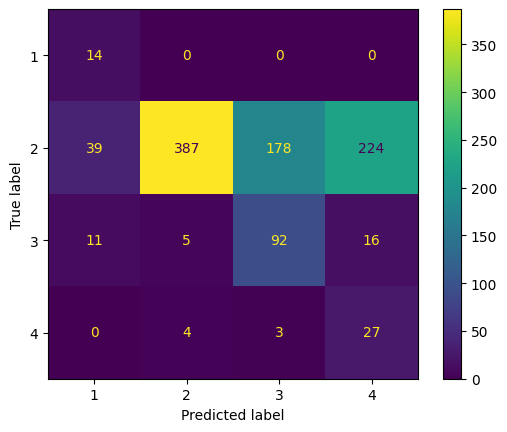

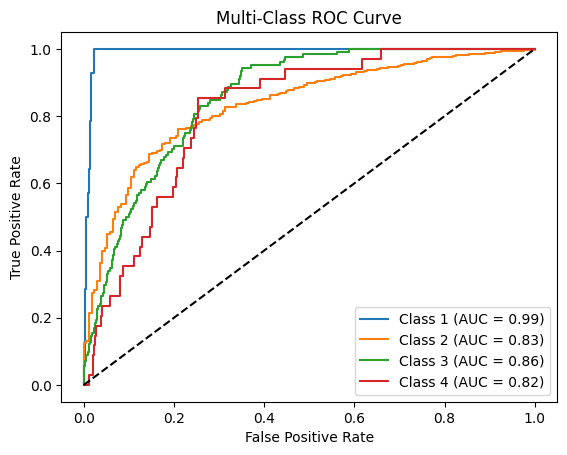


Evaluate (Test Set):
Accuracy: 0.533
F1 Score: 0.6245783185103687
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.51      0.67       857
           3       0.32      0.68      0.43       119
           4       0.05      0.72      0.10        18

    accuracy                           0.53      1000
   macro avg       0.37      0.73      0.35      1000
weighted avg       0.87      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 32 433 172 220]
 [ 12  10  81  16]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.533
Accuracy2 (One-off accuracy): 0.765


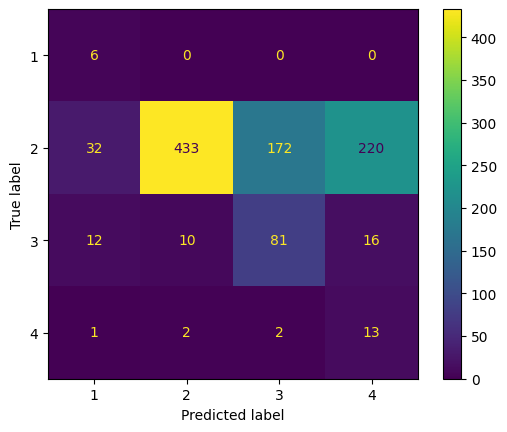

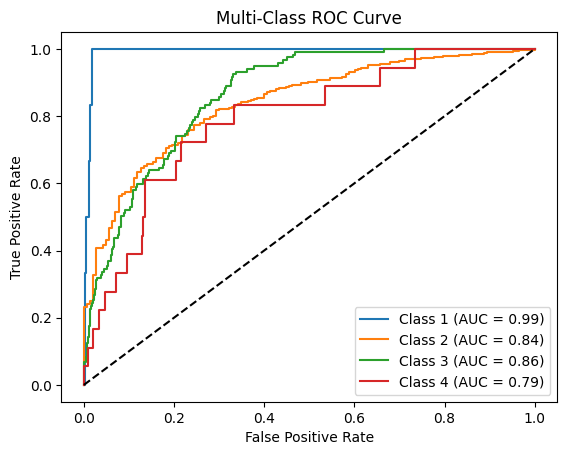

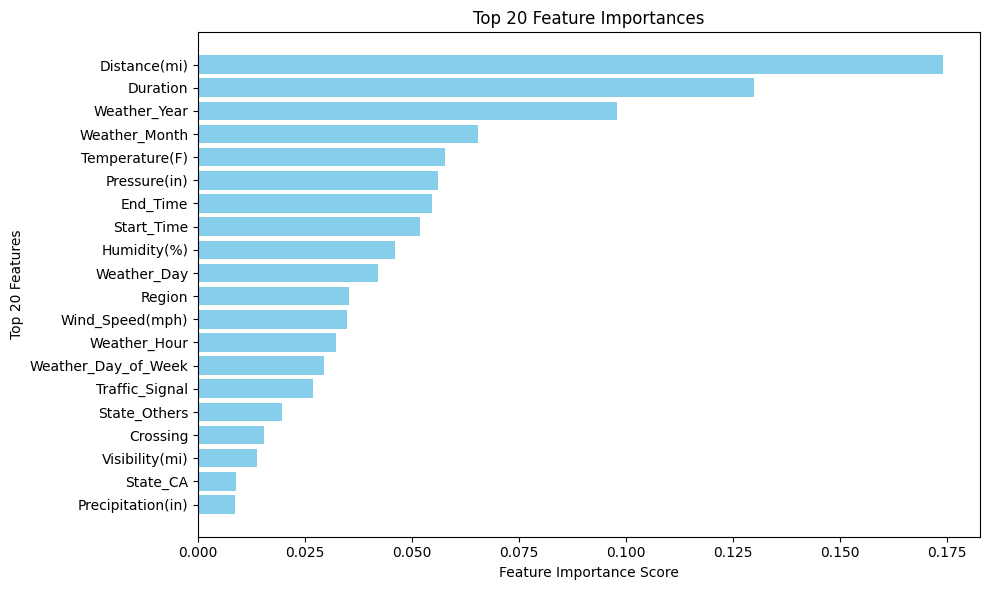

In [52]:

scorer = make_scorer(mean_absolute_error, greater_is_better=False)
best_model_mse1, best_params_mse1 = tune_evaluate(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    scorer=scorer,
    n_features=20
)